<a href="https://colab.research.google.com/github/mansikataria/AlzheimerDetection/blob/master/AlzheimersDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

Here, I am going to use the Alzheimer's Feature dataset from Kaggle: 

This is a tabular dataset with following features:

"Group" is a target for models
```
Group --> Class
Age --> Age
EDUC --> Years of Education
SES --> Socioeconomic Status / 1-5
MMSE --> Mini Mental State Examination
CDR --> Clinical Dementia Rating
eTIV --> Estimated total intracranial volume
nWBV --> Normalize Whole Brain Volume
ASF --> Atlas Scaling Factor
```

You can download the dataset from kaggle: https://www.kaggle.com/brsdincer/alzheimer-features
or Google Drive: https://drive.google.com/file/d/1hLq1MoD7RJzi7D7jlz-diD74p6iMK31Y/view?usp=sharing




Let us now implement a regression model to detect Alzheimer's disease based on data.

##Imports

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier

## Import data to pandas DataFrame

In [50]:
# Upload this file in google drive at location: '/content/drive/MyDrive/Colab Notebooks/AlzheimerDetection'
ALZHEIMER_FEATURES_FILE_NAME = "alzheimer.csv"

In [51]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/AlzheimerDetection'
sys.path.insert(0,BASE_PATH)

Mounted at /content/drive


In [52]:
data = pd.read_csv(BASE_PATH + "/" + ALZHEIMER_FEATURES_FILE_NAME)
data = AlzheimerData.copy() # for VISUALIZATION
data["Group"] = pd.Categorical(data["Group"])
data["M/F"] = pd.Categorical(data["M/F"])
data["SES"] = pd.Categorical(data["SES"])
data["CDR"] = pd.Categorical(data["CDR"])
data["EDUC"] = pd.Categorical(data["EDUC"])
data["Age"] = pd.Categorical(data["Age"])

df = data.select_dtypes(include=["float64","int64","int32"])

### Data Information and Visualization

In [53]:
data.head(5)

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [54]:
print(data.shape)
print("-."*40)
print(data.columns)
print("-."*40)
print(data.info())
print("-."*40)
print(data.describe().T)

(373, 10)
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Index(['Group', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV',
       'ASF'],
      dtype='object')
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Group   373 non-null    category
 1   M/F     373 non-null    category
 2   Age     373 non-null    category
 3   EDUC    373 non-null    category
 4   SES     354 non-null    category
 5   MMSE    371 non-null    float64 
 6   CDR     373 non-null    category
 7   eTIV    373 non-null    int64   
 8   nWBV    373 non-null    float64 
 9   ASF     373 non-null    float64 
dtypes: category(6), float64(3), int64(1)
memory usage: 16.5 KB
None
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
    

In [55]:
print(data.groupby(["Group","SES"])["MMSE"].mean())
print("-."*40)
print(data.groupby(["Group","SES"])["eTIV"].mean())
print("-."*40)
print(data.groupby(["Group","SES"])["nWBV"].mean())
print("-."*40)
print(data.groupby(["Group","SES"])["ASF"].mean())



Group        SES
Converted    1.0    28.619048
             2.0    28.571429
             3.0    29.142857
             4.0    28.000000
             5.0          NaN
Demented     1.0    23.884615
             2.0    24.480000
             3.0    25.545455
             4.0    23.657895
             5.0    22.800000
Nondemented  1.0    29.439024
             2.0    29.281690
             3.0    28.904762
             4.0    29.323529
             5.0    28.000000
Name: MMSE, dtype: float64
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Group        SES
Converted    1.0    1495.666667
             2.0    1379.142857
             3.0    1413.285714
             4.0    1518.500000
             5.0            NaN
Demented     1.0    1677.153846
             2.0    1492.360000
             3.0    1411.757576
             4.0    1450.973684
             5.0    1335.800000
Nondemented  1.0    1542.707317
             2.0    1499.140845
             3.0    1471

In [56]:
print(data.groupby(["Group","CDR"])["MMSE"].mean())
print("-."*40)
print(data.groupby(["Group","CDR"])["eTIV"].mean())
print("-."*40)
print(data.groupby(["Group","CDR"])["nWBV"].mean())
print("-."*40)
print(data.groupby(["Group","CDR"])["ASF"].mean())

Group        CDR
Converted    0.0    29.055556
             0.5    28.315789
             1.0          NaN
             2.0          NaN
Demented     0.0          NaN
             0.5    25.960784
             1.0    21.051282
             2.0    20.333333
Nondemented  0.0    29.239362
             0.5    28.000000
             1.0          NaN
             2.0          NaN
Name: MMSE, dtype: float64
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Group        CDR
Converted    0.0    1425.722222
             0.5    1491.052632
             1.0            NaN
             2.0            NaN
Demented     0.0            NaN
             0.5    1479.382353
             1.0    1498.121951
             2.0    1538.000000
Nondemented  0.0    1492.712766
             0.5    1757.500000
             1.0            NaN
             2.0            NaN
Name: eTIV, dtype: float64
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Group 

In [57]:
print(data["Group"].value_counts())
print("-."*40)
print(data["EDUC"].value_counts())
print("-."*40)
print(data["M/F"].value_counts())
print("-."*40)
print(df.corr())
print("-."*40)
print(data.isnull().sum())

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
12    103
16     81
18     64
14     33
13     27
15     17
20     13
11     11
17      9
8       9
23      3
6       3
Name: EDUC, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
F    213
M    160
Name: M/F, dtype: int64
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
          MMSE      eTIV      nWBV       ASF
MMSE  1.000000 -0.032084  0.341912  0.040052
eTIV -0.032084  1.000000 -0.210122 -0.988877
nWBV  0.341912 -0.210122  1.000000  0.213476
ASF   0.040052 -0.988877  0.213476  1.000000
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Group     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64


#### Histograms

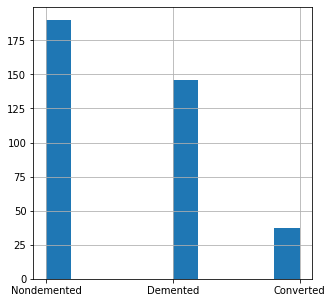

In [58]:
#Histogram of Target values
data["Group"].hist(figsize=(5,5))
plt.show()

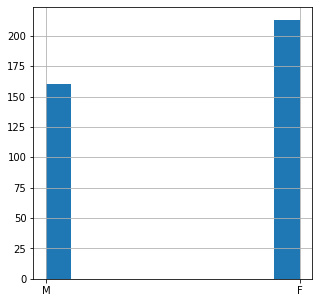

In [59]:
#Histogram of Sex Feature
data["M/F"].hist(figsize=(5,5))
plt.show()

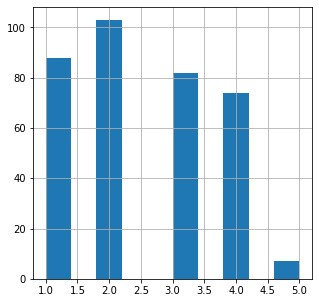

In [60]:
#Histogram of Socioeconomic Status
data["SES"].hist(figsize=(5,5))
plt.show()

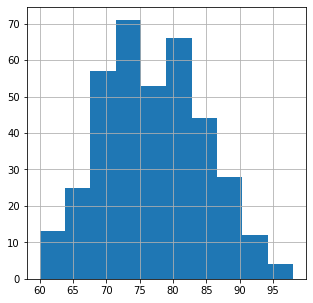

In [61]:
#Histogram of Age
data["Age"].hist(figsize=(5,5))
plt.show()

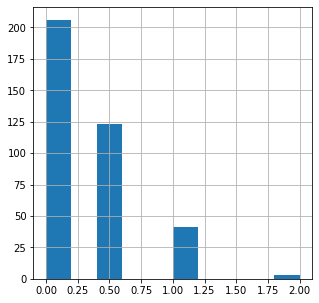

In [62]:
#Histogram of Clinical Dementia Rating
data["CDR"].hist(figsize=(5,5))
plt.show()

#### Some Scatter plot & Line plot visualizations

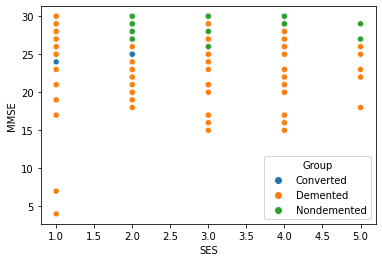

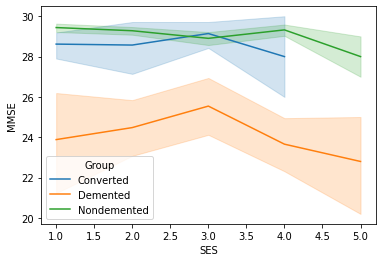

In [63]:
sns.scatterplot(x="SES",y="MMSE",hue="Group",data=data)
plt.show()
sns.lineplot(x="SES", y="MMSE",hue="Group", data=data)
plt.show()

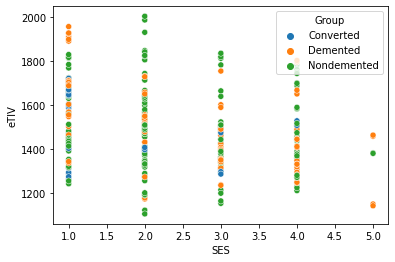

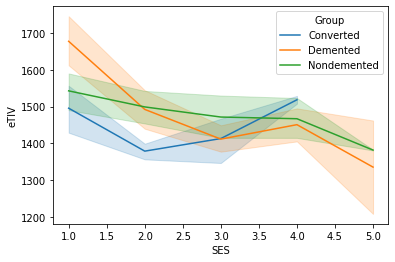

In [64]:
sns.scatterplot(x="SES",y="eTIV",hue="Group",data=data)
plt.show()
sns.lineplot(x="SES", y="eTIV",hue="Group", data=data)
plt.show()

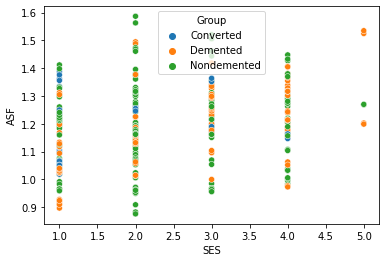

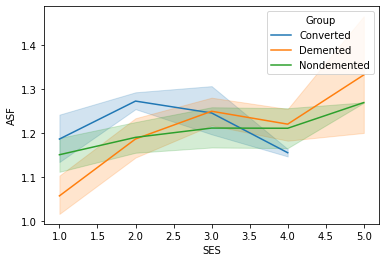

In [65]:
sns.scatterplot(x="SES",y="ASF",hue="Group",data=data)
plt.show()
sns.lineplot(x="SES", y="ASF",hue="Group", data=data)
plt.show()

#### Visualizing the correlations

In [66]:
Features = ["MMSE","eTIV","nWBV","ASF"]

In [67]:
corrPearson = data[Features].corr(method="pearson")

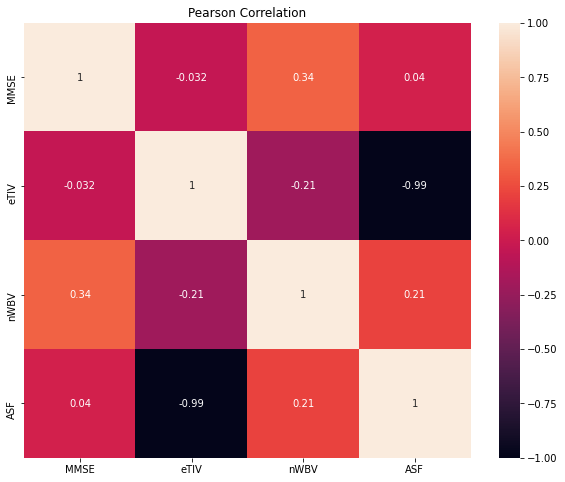

In [68]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(corrPearson,annot=True, vmin=-1, vmax=+1)

plt.title("Pearson Correlation")
plt.show()

### Data Preprocessing

Group:
```
Converted = 0
Demented = 1
Nondemented = 2
```
M/F:
```
F = 0
M = 1
```

In [69]:
Columns = ["Group","M/F"]
encode = LabelEncoder()
for i in Columns:
    print(data[i].value_counts())
    print("----")
    data[i] = encode.fit_transform(data[i])
    print(data[i].value_counts())
    print("----"*30)

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64
----
2    190
1    146
0     37
Name: Group, dtype: int64
------------------------------------------------------------------------------------------------------------------------
F    213
M    160
Name: M/F, dtype: int64
----
0    213
1    160
Name: M/F, dtype: int64
------------------------------------------------------------------------------------------------------------------------


In [70]:
data["SES"] = AlzheimerData["SES"]
data["CDR"] = AlzheimerData["CDR"]
data["EDUC"] = AlzheimerData["EDUC"]
data["Age"] = AlzheimerData["Age"]

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group   373 non-null    int64  
 1   M/F     373 non-null    int64  
 2   Age     373 non-null    int64  
 3   EDUC    373 non-null    int64  
 4   SES     354 non-null    float64
 5   MMSE    371 non-null    float64
 6   CDR     373 non-null    float64
 7   eTIV    373 non-null    int64  
 8   nWBV    373 non-null    float64
 9   ASF     373 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 29.3 KB
None


#### Fill in missing data

In [71]:
data["SES"].fillna(data["SES"].mean(), inplace=True)
data["MMSE"].fillna(data["MMSE"].mean(), inplace=True)
print(data.isnull().sum())

Group    0
M/F      0
Age      0
EDUC     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64


#### Divide data into train and test set

In [72]:
x = data.drop("Group",axis=1)
y = data["Group"]

xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=0.20,random_state=42)

### Training and Prediction

####Regression Classifier Tree (CART)

In [73]:
print("==============Results from Decision Tree Classifier before tuning==============")
cartc = DecisionTreeClassifier().fit(xTrain,yTrain)
predict = cartc.predict(xTest)

print("Accuracy Score: ", accuracy_score(yTest,predict))
R2CV = cross_val_score(cartc,xTest,yTest,cv=10).mean()
print("Cross Validaition Score: ", R2CV)

error = mean_squared_error(yTest,predict)
print("Mean Squared Error: ", np.sqrt(error))

print("==============Results from Decision Tree Classifier after tuning==============")
cartctuned = DecisionTreeClassifier(max_depth=1,min_samples_split=2).fit(xTrain,yTrain)
predicttuned = cartctuned.predict(xTest)
print("Accuracy Score: ", accuracy_score(yTest,predicttuned))
R2CVtuned = cross_val_score(cartctuned,xTest,yTest,cv=10).mean()
print("Cross Validaition Score: ",R2CVtuned)

errortuned = mean_squared_error(yTest,predicttuned)
print("Mean Squared Error: ",np.sqrt(errortuned))

==============Results from Decision Tree Classifier before tuning==============
Accuracy Score:  0.8533333333333334
Cross Validaition Score:  0.8017857142857142
Mean Squared Error:  0.6531972647421809
==============Results from Decision Tree Classifier after tuning==============
Accuracy Score:  0.84
Cross Validaition Score:  0.8392857142857142
Mean Squared Error:  0.6928203230275509


####XGBoost Classifier

In [74]:
xgbc = XGBClassifier(verbose=False).fit(xTrain,yTrain)
predict = xgbc.predict(xTest)
print("==============Results from XGB Classifier before tuning==============")
print("Accuracy Score: ", accuracy_score(yTest,predict))
R2CV = cross_val_score(xgbc,xTest,yTest,cv=10).mean()
print("Cross Validation Score: ", R2CV)
# 0.84
error = mean_squared_error(yTest,predict)
print("Root Mean Squared Error: ", np.sqrt(error))


xgbctuned = XGBClassifier(learning_rate=0.01, max_depth=6, min_samples_split=2,
                              n_estimators=100, subsample=0.8).fit(xTrain, yTrain)
print("==============Results from XGB Classifier after tuning==============")
predicttuned = xgbctuned.predict(xTest)
print("Accuracy Score: ", accuracy_score(yTest,predicttuned))
R2CVtuned = cross_val_score(xgbctuned,xTest,yTest,cv=10).mean()
print("Cross Validation Score: ", R2CVtuned)
# 0.82
errortuned = mean_squared_error(yTest,predicttuned)
print("Root Mean Squared Error: ", np.sqrt(errortuned))


==============Results from XGB Classifier before tuning==============
Accuracy Score:  0.8533333333333334
Cross Validation Score:  0.8285714285714285
Root Mean Squared Error:  0.6531972647421809
==============Results from XGB Classifier after tuning==============
Accuracy Score:  0.84
Cross Validation Score:  0.8285714285714285
Root Mean Squared Error:  0.6928203230275509


#### Comparing the two classifiers

----------------------------
DecisionTreeClassifier: 
Accuracy: 0.84
----------------------------
XGBClassifier: 
Accuracy: 0.8533333333333334


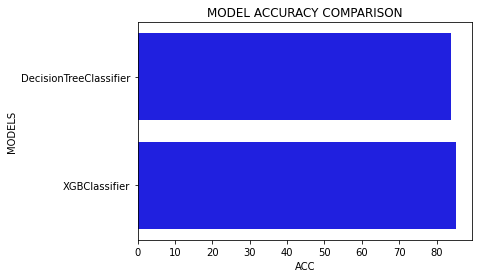

In [75]:
models = [cartctuned,xgbc]
r = pd.DataFrame(columns=["MODELS","ACC"])

for model in models:
    name = model.__class__.__name__
    predict = model.predict(xTest)
    accuracy = accuracy_score(yTest, predict)
    print("-" * 28)
    print(name + ": ")
    print(f"Accuracy: {accuracy}")
    result = pd.DataFrame([[name,accuracy*100]],columns=["MODELS","ACC"])
    r = r.append(result)
    
sns.barplot(x="ACC",y="MODELS",data=r,color="b")
plt.xlabel("ACC")
plt.title("MODEL ACCURACY COMPARISON")
plt.show()

In [77]:
%%shell
jupyter nbconvert --to html /content/AlzheimersDetection.ipynb

[NbConvertApp] Converting notebook /content/AlzheimersDetection.ipynb to html
[NbConvertApp] Writing 587164 bytes to /content/AlzheimersDetection.html
